In [1]:
!pip install -U decoupler

In [2]:
from google.colab import drive
drive.mount("/content/drive")

# CHANGE THIS PATH to wherever you stored your .h5ad file in Drive
data_path = "/content/drive/MyDrive/bone_marrow.h5ad"

# Quick check: does the file exist?
import os
print("File exists:", os.path.exists(data_path), " -> ", data_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
File exists: True  ->  /content/drive/MyDrive/bone_marrow.h5ad


In [3]:
pip install scanpy

In [4]:
import scanpy as sc
import pandas as pd
import decoupler as dc

# 1) Download Ensembl ID ↔ gene name table
!wget -O /content/result.txt 'http://www.ensembl.org/biomart/martservice?query=<?xml version="1.0" encoding="UTF-8"?><!DOCTYPE Query><Query  virtualSchemaName = "default" formatter = "CSV" header = "0" uniqueRows = "0" count = "" datasetConfigVersion = "0.6" ><Dataset name = "hsapiens_gene_ensembl" interface = "default" ><Attribute name = "ensembl_gene_id" /><Attribute name = "external_gene_name" /></Dataset></Query>'

# 2) Read the Ensembl mapping table
ensembl_var = pd.read_csv('/content/result.txt', header=None)
ensembl_var.columns = ['ensembl_gene_id', 'gene_name']

# 3) Load the bone marrow scRNA-seq dataset into `adata`
adata = sc.read_h5ad(data_path)

# 4) Get PanglaoDB markers from decoupler
markers = dc.op.resource(name="PanglaoDB", organism="human")

# 5) Clean and format markers (cell_type + gene symbol)
markers = markers[~markers.duplicated(["cell_type", "genesymbol"])]
markers = markers.rename(columns={"cell_type": "source", "genesymbol": "target"})
markers = markers[["source", "target"]]

# 6) Map gene symbols to Ensembl IDs using the Ensembl table
markers = markers.merge(ensembl_var, left_on="target", right_on="gene_name", how="left")
markers = markers.drop(columns=["target"])
markers = markers[~markers.duplicated(["source", "ensembl_gene_id"])]
markers = markers.rename(columns={"ensembl_gene_id": "target"})
markers = markers[["source", "target"]].dropna()

# Sanity check
print(adata)
print(markers.head())


--2025-12-30 02:56:23--  http://www.ensembl.org/biomart/martservice?query=%3C?xml%20version=%221.0%22%20encoding=%22UTF-8%22?%3E%3C!DOCTYPE%20Query%3E%3CQuery%20%20virtualSchemaName%20=%20%22default%22%20formatter%20=%20%22CSV%22%20header%20=%20%220%22%20uniqueRows%20=%20%220%22%20count%20=%20%22%22%20datasetConfigVersion%20=%20%220.6%22%20%3E%3CDataset%20name%20=%20%22hsapiens_gene_ensembl%22%20interface%20=%20%22default%22%20%3E%3CAttribute%20name%20=%20%22ensembl_gene_id%22%20/%3E%3CAttribute%20name%20=%20%22external_gene_name%22%20/%3E%3C/Dataset%3E%3C/Query%3E
Resolving www.ensembl.org (www.ensembl.org)... 193.62.193.83
Connecting to www.ensembl.org (www.ensembl.org)|193.62.193.83|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/plain]
Saving to: ‘/content/result.txt’

/content/result.txt     [      <=>           ]   1.71M  1.44MB/s    in 1.2s    

2025-12-30 02:56:25 (1.44 MB/s) - ‘/content/result.txt’ saved [1795328]

AnnData object with

# **Attach gene symbols and mark mitochondrial genes**

In [5]:
# Add gene names to adata.var using the ensembl_var table
import pandas as pd

var_df = adata.var.reset_index()
var_df = var_df.rename(columns={"index": "ensembl_gene_id"})

var_df = var_df.merge(
    ensembl_var,
    on="ensembl_gene_id",
    how="left"
)

var_df = var_df.set_index("ensembl_gene_id")
adata.var = var_df

# Mark mitochondrial genes
adata.var["mt"] = adata.var["gene_name"].str.startswith("MT-")

adata.var.head()


,n_cells,feature_is_filtered,feature_name,feature_reference,feature_biotype,feature_length,feature_type,gene_name,mt
ensembl_gene_id,,,,,,,,,
ENSG00000161920,927,False,MED11,NCBITaxon:9606,gene,754,protein_coding,MED11,False
ENSG00000122335,429,False,SERAC1,NCBITaxon:9606,gene,2683,protein_coding,SERAC1,False
ENSG00000175548,149,False,ALG10B,NCBITaxon:9606,gene,1773,protein_coding,ALG10B,False
ENSG00000100330,426,False,MTMR3,NCBITaxon:9606,gene,634,protein_coding,MTMR3,False
ENSG00000176340,7171,False,COX8A,NCBITaxon:9606,gene,494,protein_coding,COX8A,False


# **Run QC**

In [6]:
# Fix the mitochondrial column so it has only True / False (no NaN)
adata.var["mt"] = adata.var["mt"].fillna(False).astype(bool)

# Now safely compute QC metrics
import scanpy as sc
sc.pp.calculate_qc_metrics(
    adata,
    qc_vars=["mt"],
    inplace=True
)

adata.obs.head()


/tmp/ipython-input-2547941534.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  adata.var["mt"] = adata.var["mt"].fillna(False).astype(bool)


,disease stage,treatment,timepoint,Dataset,sample,disease_original,disease_general,COVID-19 Condition,Lineage,Cell.group,...,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,total_counts_mt,log1p_total_counts_mt,pct_counts_mt
index,,,,,,,,,,,,,,,,,,,,,
Guo-AAACCTGAGAGCTTCT-2,severe,400 mg Tocilizumab at day 1,day 1,Guo et al._Nature Communication,Guo_P1-day1-rep2,COVID-19 Severe,COVID-19 Severe/Late stage/Vent,severe,Myeloid,CD14+ Monocyte,...,7.249926,11982.381836,9.391276,5.229761,9.910657,18.420549,40.537370,138.356339,4.937034,1.154665
Guo-AAACCTGAGAGGTTGC-7,remission,400 mg Tocilizumab at day 1,day 7,Guo et al._Nature Communication,Guo_P2-day7,COVID-19 Mild/Remission,COVID-19 Remission,remission,Lymphoid_T/NK,CD8+ T cell,...,6.806829,8430.891602,9.039777,7.532181,14.238965,26.142280,57.850376,113.859787,4.743712,1.350507
Guo-AAACCTGAGATACACA-3,remission,400 mg Tocilizumab at day 1,day 5,Guo et al._Nature Communication,Guo_P1-day5-rep1,COVID-19 Mild/Remission,COVID-19 Remission,remission,Lymphoid_T/NK,CD4+ T cell,...,6.777647,8103.278809,9.000148,7.871431,14.867313,27.103972,59.749640,125.068520,4.836825,1.543431
Guo-AAACCTGAGCGATTCT-1,severe,400 mg Tocilizumab at day 1,day 1,Guo et al._Nature Communication,Guo_P1-day1-rep1,COVID-19 Severe,COVID-19 Severe/Late stage/Vent,severe,Lymphoid_T/NK,CD8+ T cell,...,6.839476,8748.598633,9.076763,7.115205,13.512491,25.060052,56.156243,103.474380,4.648942,1.182754
Guo-AAACCTGAGTGAAGAG-3,remission,400 mg Tocilizumab at day 1,day 5,Guo et al._Nature Communication,Guo_P1-day5-rep1,COVID-19 Mild/Remission,COVID-19 Remission,remission,Lymphoid_T/NK,CD4+ T cell,...,6.148468,4826.668457,8.482119,13.202208,24.706561,45.388216,100.000121,138.531082,4.938287,2.870118


## **Filter low-quality cells**

In [7]:
# Standard QC filtering
import numpy as np

# Remove cells with too few / too many genes
adata = adata[adata.obs['n_genes_by_counts'] > 200, :]
adata = adata[adata.obs['n_genes_by_counts'] < 6000, :]

# Remove cells with too high mitochondrial content
adata = adata[adata.obs['pct_counts_mt'] < 10, :]

adata


View of AnnData object with n_obs × n_vars = 14783 × 17374
    obs: 'disease stage', 'treatment', 'timepoint', 'Dataset', 'sample', 'disease_original', 'disease_general', 'COVID-19 Condition', 'Lineage', 'Cell.group', 'Cell.class_reannotated', 'n_genes', 'n_counts', 'percent_mito', 'tissue_original', 'tissue_ontology_term_id', 'disease_ontology_term_id', 'donor_id', 'development_stage_ontology_term_id', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'sex_ontology_term_id', 'is_primary_data', 'suspension_type', 'tissue_type', 'assay', 'disease', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'feature_is_filtered

# **Normalize the counts and log-transform**

In [8]:
import scanpy as sc

# Normalize total counts per cell and log-transform
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

adata


/usr/local/lib/python3.12/dist-packages/scanpy/preprocessing/_normalization.py:269: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


AnnData object with n_obs × n_vars = 14783 × 17374
    obs: 'disease stage', 'treatment', 'timepoint', 'Dataset', 'sample', 'disease_original', 'disease_general', 'COVID-19 Condition', 'Lineage', 'Cell.group', 'Cell.class_reannotated', 'n_genes', 'n_counts', 'percent_mito', 'tissue_original', 'tissue_ontology_term_id', 'disease_ontology_term_id', 'donor_id', 'development_stage_ontology_term_id', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'sex_ontology_term_id', 'is_primary_data', 'suspension_type', 'tissue_type', 'assay', 'disease', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'feature_is_filtered', 'feat

# **Highly variable genes**

In [9]:
import scanpy as sc

# Pick the top 2000 highly variable genes
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=2000,
    flavor="seurat"   # NOT seurat_v3 (avoids the skmisc error)
)

# Keep only highly variable genes
adata = adata[:, adata.var["highly_variable"]].copy()

adata


AnnData object with n_obs × n_vars = 14783 × 2000
    obs: 'disease stage', 'treatment', 'timepoint', 'Dataset', 'sample', 'disease_original', 'disease_general', 'COVID-19 Condition', 'Lineage', 'Cell.group', 'Cell.class_reannotated', 'n_genes', 'n_counts', 'percent_mito', 'tissue_original', 'tissue_ontology_term_id', 'disease_ontology_term_id', 'donor_id', 'development_stage_ontology_term_id', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'sex_ontology_term_id', 'is_primary_data', 'suspension_type', 'tissue_type', 'assay', 'disease', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'feature_is_filtered', 'featu

# **PCA**

In [10]:
import scanpy as sc

# Scale genes and run PCA
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver="arpack")

adata.obsm["X_pca"][:5]  # just to confirm PCA exists


/usr/lib/python3.12/functools.py:912: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


array([[ 5.555942  , 10.543696  , -5.418796  , -2.5851433 , -1.2092446 ,
        -1.2747455 ,  0.27416041,  1.7886767 , -0.41076863,  0.9678118 ,
         0.15864576, -1.0735159 ,  0.9410173 ,  0.67877936,  0.25566158,
        -1.079028  ,  1.184157  , -0.5392174 , -1.0760509 , -1.4755341 ,
        -1.3719876 , -2.165844  , -0.73228866, -1.4010891 ,  0.1971326 ,
         0.6045778 , -0.89138377,  0.88563246,  0.55598754, -1.048158  ,
         0.8730042 , -0.44566005, -0.26830527,  0.62809134, -0.5890157 ,
         0.02455229, -0.45020393, -0.3038642 ,  0.10516263,  0.196236  ,
        -0.7944826 ,  1.2860502 ,  0.27374947, -0.10899849,  0.5013861 ,
        -0.3544051 , -1.160445  , -0.0378909 , -0.4591255 ,  0.7581889 ],
       [-2.0709462 , -0.45272955, -0.44702825,  4.2390847 ,  2.4545465 ,
        -0.24032485, -0.03830497,  0.23192352, -0.7158439 ,  0.31798884,
        -0.45575884, -0.7114893 , -1.1274167 , -1.2442569 ,  0.82294357,
         0.11495198, -0.5124427 , -0.51724064,  0.

# **compute UMAP + Leiden clustering**

In [11]:
!pip install python-igraph leidenalg


In [12]:
import scanpy as sc

# Compute neighbors from PCA
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=40)

# Compute UMAP embedding
sc.tl.umap(adata)

# Cluster cells
sc.tl.leiden(adata, resolution=0.5)

adata.obs['leiden'].value_counts()


/tmp/ipython-input-2707229829.py:10: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.5)


,count
leiden,
0,4144
1,2661
2,1656
3,1237
4,1071
5,938
6,816
7,791
8,601


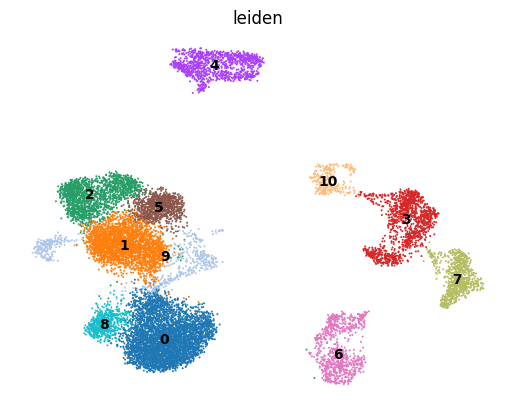

In [13]:
import scanpy as sc

sc.pl.umap(adata, color="leiden", legend_loc="on data", frameon=False)


# **cell type annotation**

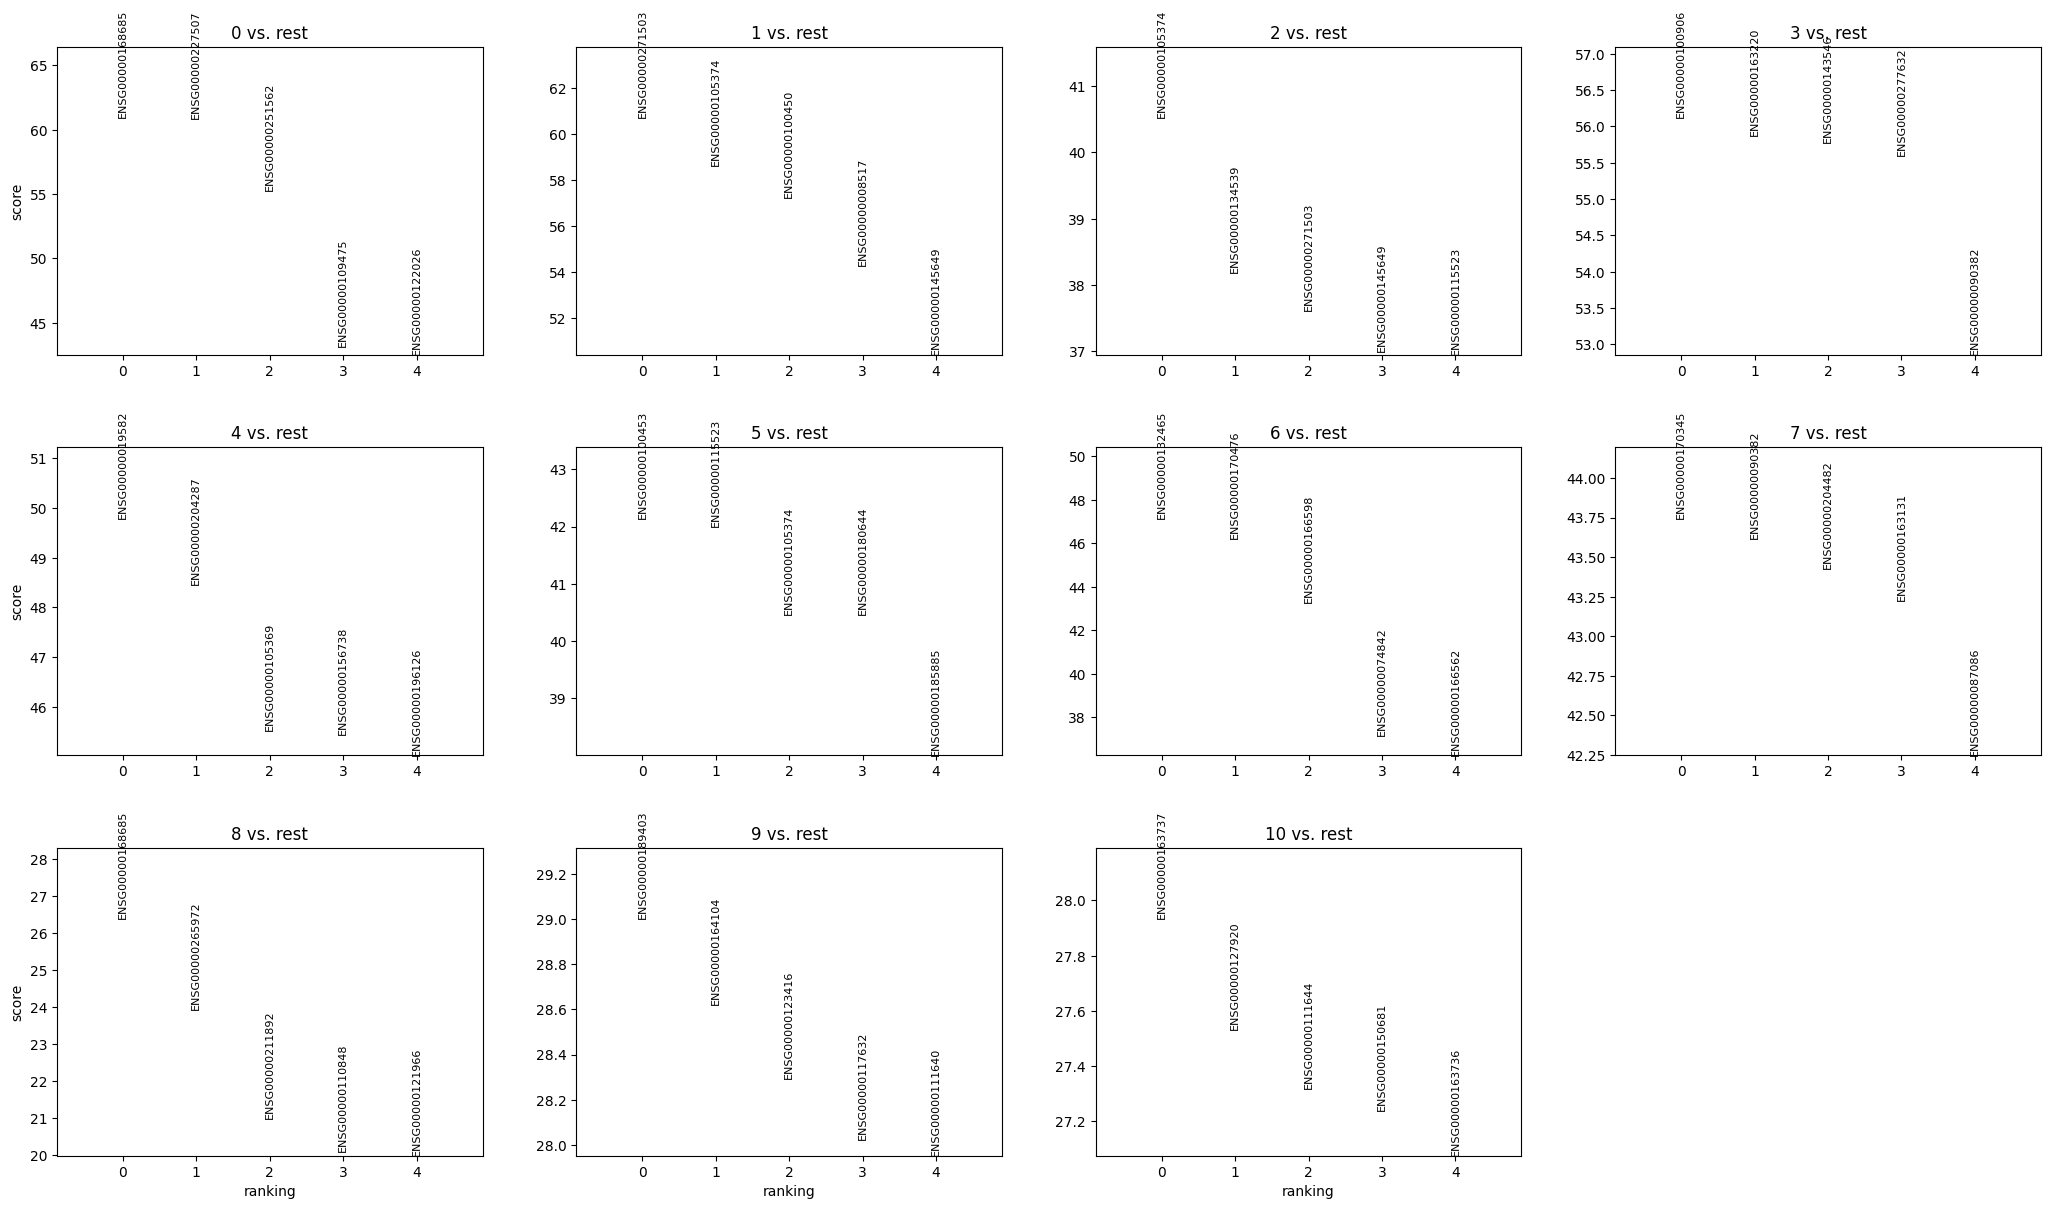

In [28]:
import scanpy as sc

sc.tl.rank_genes_groups(
    adata,
    groupby="leiden",
    method="wilcoxon"
)

sc.pl.rank_genes_groups(adata, n_genes=5, sharey=False)


In [29]:
import scanpy as sc
import pandas as pd

# Recompute markers using processed data
sc.tl.rank_genes_groups(
    adata,
    groupby="leiden",
    method="wilcoxon",
    use_raw=False
)

# Convert result to dataframe
markers_df = sc.get.rank_genes_groups_df(adata, group=None)

# Map Ensembl to gene symbols
mapping = dict(zip(ensembl_var['ensembl_gene_id'], ensembl_var['gene_name']))
markers_df['gene_symbol'] = markers_df['names'].map(mapping)

# Show top genes per cluster with readable names
markers_df.head(20)


/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:484: 

,group,names,scores,logfoldchanges,pvals,pvals_adj,gene_symbol
0,0,ENSG00000227507,67.813202,NaN,0.0,0.0,LTB
1,0,ENSG00000168685,64.993996,NaN,0.0,0.0,IL7R
2,0,ENSG00000265681,64.175125,NaN,0.0,0.0,RPL17
3,0,ENSG00000171858,63.994137,NaN,0.0,0.0,RPS21
4,0,ENSG00000213741,63.224590,NaN,0.0,0.0,RPS29
5,0,ENSG00000112306,61.974949,NaN,0.0,0.0,RPS12
6,0,ENSG00000172809,61.801430,NaN,0.0,0.0,RPL38
7,0,ENSG00000071082,61.507172,NaN,0.0,0.0,RPL31
8,0,ENSG00000198918,61.114258,NaN,0.0,0.0,RPL39
9,0,ENSG00000109475,60.691471,NaN,0.0,0.0,RPL34


In [30]:
top_markers = (
    markers_df
    .groupby("group")
    .head(10)[["group","gene_symbol","scores"]]
)

top_markers


/tmp/ipython-input-4221055607.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("group")


,group,gene_symbol,scores
0,0,LTB,67.813202
1,0,IL7R,64.993996
2,0,RPL17,64.175125
3,0,RPS21,63.994137
4,0,RPS29,63.224590
...,...,...,...
20005,10,PPBP,26.840527
20006,10,CAVIN2,26.673155
20007,10,RGS10,24.097830
20008,10,LIMS1,24.011902


In [31]:
cluster_summary = (
    markers_df.groupby("group")
    .head(3)[["group","gene_symbol"]]
    .groupby("group")["gene_symbol"]
    .apply(list)
)

cluster_summary


/tmp/ipython-input-4083290296.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  markers_df.groupby("group")
/tmp/ipython-input-4083290296.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("group")["gene_symbol"]


,gene_symbol
group,
0,"[LTB, IL7R, RPL17]"
1,"[NKG7, CCL5, GNLY]"
2,"[NKG7, GNLY, CCL5]"
3,"[CCL3, LYZ, CXCL8]"
4,"[HLA-DRA, CD79A, MS4A1]"
5,"[GNLY, TYROBP, NKG7]"
6,"[MZB1, JCHAIN, HSP90B1]"
7,"[FCN1, LST1, LYZ]"
8,"[IL7R, IGLC2, IGHG4]"


In [32]:
cluster_to_celltype = {
    '0': 'T cells (IL7R+)',
    '1': 'Cytotoxic T / NK',
    '2': 'Cytotoxic T / NK',
    '3': 'Inflammatory Monocytes',
    '4': 'B cells',
    '5': 'NK cells',
    '6': 'Plasma cells',
    '7': 'Classical Monocytes',
    '8': 'Memory / Activated B',
    '9': 'Proliferating cells',
    '10': 'Megakaryocytes / Platelets'
}

adata.obs['cell_type'] = adata.obs['leiden'].map(cluster_to_celltype)
adata.obs[['leiden','cell_type']].head()


,leiden,cell_type
index,,
Guo-AAACCTGAGAGCTTCT-2,3,Inflammatory Monocytes
Guo-AAACCTGAGAGGTTGC-7,1,Cytotoxic T / NK
Guo-AAACCTGAGATACACA-3,0,T cells (IL7R+)
Guo-AAACCTGAGCGATTCT-1,2,Cytotoxic T / NK
Guo-AAACCTGAGTGAAGAG-3,0,T cells (IL7R+)


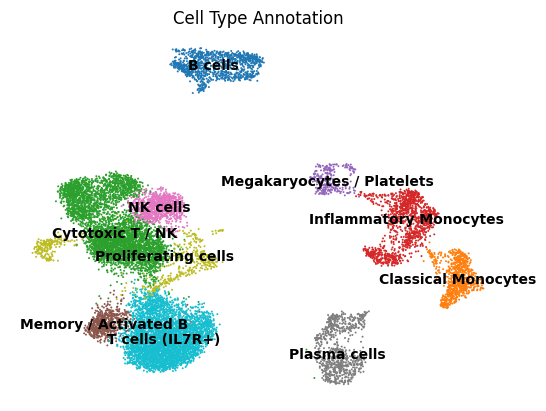

In [33]:
sc.pl.umap(
    adata,
    color="cell_type",
    legend_loc="on data",
    frameon=False,
    title="Cell Type Annotation"
)
